## Capstone project Pricify

#### Business Understanding

The goal is to build a model to predict a price for item by picture. As OfferUp says that "With a single snap, you can take a photo of an item and instantly circulate it to people nearby.", it sounds interesting to suggest the price, so you can take a photo of item and decide either you should sell it or not.

### Data Understanding

OfferUp scraping

scrap_offerup.rb  - HTTP Request to https://offerupnow.com/ and scrap the recent offers page by page until the date limit was reached. Each offer was stored into file in JSON format. 

normalize_scraped.rb - Spliting and combining offers into 3 JSON files, I got:
offerup-data
* items.json 605 Mb 380,107 items
* owners.json 141.2 Mb ? item owners
* images.json 214.1 Mb ? links to item images

download_images.rb - 3 size of images organizes into subfolders with offer-id name.
* detail
* full
* list


./scrap_offerup.rb -c /tmp/cookie.txt -s ./scraped -t 0 -n 20000 -p 0.5 | tee scrap.log

In [3]:
import pandas as pd
import matplotlib
%matplotlib inline

In [4]:
df = pd.read_json('../data/items.json')

In [5]:
cdf = df.copy()

In [6]:
df.shape

(380107, 34)

In [7]:
df.head()

,category,condition,description,distance,get_full_url,get_img_medium_height,get_img_medium_width,get_img_permalink_large,get_img_permalink_medium,get_img_permalink_small,...,post_from_store_address,price,priority,reservable,reserved,review_status,sold_date,sold_offer_id,state,title
0,"{u'id': 2, u'name': u'Household'}",40,Colorful mosaic that brightens up a room! 1.5'...,15,https://offerupnow.com/item/detail/96366652/fl...,400,300,https://d2j6tswx2otu6e.cloudfront.net/V_DoSoMA...,https://d2j6tswx2otu6e.cloudfront.net/8toAz7Tj...,https://d2j6tswx2otu6e.cloudfront.net/KPORxbgy...,...,"Lynnwood, WA",10,100,False,False,2,None,NaN,3,Fleur d' lys mosaic artwork
1,"{u'id': 13, u'name': u'Beauty & Health'}",100,2 NYX Avant Pop Palettes. Has 10 different eye...,15,https://offerupnow.com/item/detail/96366557/ny...,400,300,https://d2j6tswx2otu6e.cloudfront.net/lv6RLzOC...,https://d2j6tswx2otu6e.cloudfront.net/z0pDlQul...,https://d2j6tswx2otu6e.cloudfront.net/OujFPQXl...,...,"Lynnwood, WA",25,100,False,False,2,None,NaN,3,NYX Avant Pop Palettes
2,"{u'id': 3, u'name': u'General'}",40,Size 28 only put on once very nice jeans,18,https://offerupnow.com/item/detail/96366541/mi...,225,300,https://d2j6tswx2otu6e.cloudfront.net/gY13xLL9...,https://d2j6tswx2otu6e.cloudfront.net/-5KLMMcI...,https://d2j6tswx2otu6e.cloudfront.net/Zqk9QmT3...,...,"Lynnwood, WA",60,100,False,False,2,None,NaN,3,Miss Me jeans
3,"{u'id': 3, u'name': u'General'}",40,Red justice jean shorts,4,https://offerupnow.com/item/detail/96366520/re...,400,300,https://d2j6tswx2otu6e.cloudfront.net/e7zVb3QB...,https://d2j6tswx2otu6e.cloudfront.net/_Sm3yKZR...,https://d2j6tswx2otu6e.cloudfront.net/ge9ot77Y...,...,"Lake Stevens, WA",3,100,False,False,2,None,NaN,3,red Justice jeans shorts
4,"{u'id': 1, u'name': u'Electronics'}",40,Great condition,26,https://offerupnow.com/item/detail/96366471/su...,400,300,https://d2j6tswx2otu6e.cloudfront.net/OqwfY7Q7...,https://d2j6tswx2otu6e.cloudfront.net/v0gyLUF5...,https://d2j6tswx2otu6e.cloudfront.net/UaGTB7eA...,...,"Seattle, WA",400,100,False,False,2,None,NaN,3,Surface pro 3 128gb


In [8]:
sample = df.sample(100)

In [9]:
sample.shape

(100, 34)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380107 entries, 0 to 380106
Data columns (total 34 columns):
category                      380107 non-null object
condition                     380107 non-null int64
description                   380107 non-null object
distance                      380107 non-null int64
get_full_url                  380107 non-null object
get_img_medium_height         380107 non-null int64
get_img_medium_width          380107 non-null int64
get_img_permalink_large       380107 non-null object
get_img_permalink_medium      380107 non-null object
get_img_permalink_small       380107 non-null object
get_img_small_height          380107 non-null int64
get_img_small_width           380107 non-null int64
get_small_square_thumbanil    380107 non-null object
id                            380107 non-null int64
image                         159857 non-null object
image_mob_det_hd              380107 non-null object
image_mob_list_hd             380107 non-null ob

#### Remove duplicates

From 380107 to 300304

In [11]:
cdf.drop_duplicates(subset='id', inplace=True)

In [12]:
cdf.shape

(300304, 34)

### Data Preparation

Start from item.json. We got 300,304 rows and 34 columns. 

Columns are: 

* category - object (calculate how many categories, split into separate table?)
* condition	 - int (40, 100 ? looks like categorical)
* description - text
* distance	- distance from logged user, not applicable
* get_full_url	- link to offer
* get_img_medium_height	400
* get_img_medium_width	300
* get_img_permalink_large
* get_img_permalink_medium
* get_img_permalink_small
* get_img_small_height
* get_img_small_width
* get_small_square_thumbanil
* id	65194613
* image	None
* image_mob_det_hd
* image_mob_list_hd
* latitude	47.8426
* listing_type	2
* location_name	Lynnwood, WA
* longitude	-122.295
* owner_id	6787474
* payable	False
* post_date	2015-12-19T19:38:50.398Z
* post_from_store_address	Lynnwood, WA
* price	25
* priority	100
* reservable	False
* reserved	False
* review_status	2
* sold_date	None
* sold_offer_id	NaN
* state	3
* title

1. Category
 - category 380107 non-null object - no missing values
 - Create two features with category data - category_id and category_name

In [13]:
cdf['category_id'] =  cdf.category.apply(lambda x: int(x['id']))

In [14]:
cdf['category_name'] =  cdf.category.apply(lambda x: str(x['name']))

In [15]:
cat_counts = cdf['category_name'].value_counts()

In [16]:
len(cat_counts)

37

In [17]:
cat_counts

Baby & Kids              37114
Clothing & Shoes         27743
Jewelry & Accessories    24671
Furniture                22857
General                  22527
Household                21974
Electronics              14967
Cell Phones              14307
Collectibles             12093
Sports & Outdoors        10963
Home & Garden             9529
Cars & Trucks             8401
Auto Parts                8261
Games & Toys              8149
Beauty & Health           6384
Tools & Machinery         6265
Arts & Crafts             5766
Antiques                  4654
Appliances                4411
Computer Equipment        3817
Audio Equipment           3673
Video Games               3166
Bicycles                  2787
Motorcycles               2582
Pet Supplies              2329
Musical Instruments       2108
Photography               1576
TVs                       1463
Boats & Marine            1167
Business Equipment        1082
CDs & DVDs                1021
Books & Magazines          508
Farming 

So, we have 37 categories of items

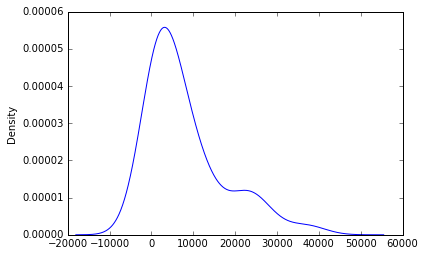

In [138]:
cat_counts.plot(kind='density')

In [19]:
#Selected features: 
features = ['id', 'description', 'title', 'category_id', 'category_name', 'price']
fdf = cdf[features]

In [22]:
phones_category = cdf[cdf['category_name'] == 'Cell Phones']

In [20]:
apparel_category = fdf[fdf['category_name'].isin(['Baby & Kids', 'Clothing & Shoes'])]
apparel_category.shape
#apparel_category.id.to_csv('apparel_category.csv', index=False)


(64857, 6)

In [21]:
house_category = fdf[fdf['category_name'].isin(['Furniture', 'Household', 'Home & Garden'])]
house_category.shape
#house_category.id.to_csv('house_category.csv', index=False)

(54360, 6)

In [300]:
phones_base = cdf[cdf['category_name'] == 'Cell Phones']
from collections import Counter
l = map(lambda x: x.split(), phones_base.title.tolist())
c = Counter([item.lower() for sublist in l for item in sublist])
c.most_common(30)

[(u'unlocked', 4096),
 (u'iphone', 3799),
 (u'galaxy', 3427),
 (u'samsung', 2979),
 (u'note', 1487),
 (u'case', 1474),
 (u'phone', 1012),
 (u's5', 980),
 (u'lg', 977),
 (u'5', 913),
 (u'4', 893),
 (u'htc', 867),
 (u's4', 812),
 (u's6', 765),
 (u'6', 704),
 (u'3', 670),
 (u'verizon', 665),
 (u'5s', 630),
 (u'for', 557),
 (u'one', 530),
 (u'new', 523),
 (u'2', 496),
 (u'sprint', 475),
 (u'4s', 473),
 (u'edge', 379),
 (u'5c', 366),
 (u't-mobile', 358),
 (u'plus', 345),
 (u'cases', 334),
 (u'at&t', 332)]

In [301]:
from collections import Counter
l = map(lambda x: x.split(), phones_base.description.tolist())
c = Counter([item.lower() for sublist in l for item in sublist])
c.most_common(30)

[(u'.', 51955),
 (u'and', 10572),
 (u'mobile', 10284),
 (u'on', 10161),
 (u'my', 9445),
 (u'to', 7886),
 (u'any', 7455),
 (u'works', 6481),
 (u'the', 5805),
 (u'is', 5517),
 (u'521', 5344),
 (u'street', 5331),
 (u'ne', 5330),
 (u'98155', 5328),
 (u'165th', 5311),
 (u'pcs', 5281),
 (u'address', 5249),
 (u'go', 5236),
 (u'shoreline', 5224),
 (u'smart', 5181),
 (u'metro', 5174),
 (u'family', 5153),
 (u'in', 5153),
 (u'att', 5083),
 (u'others', 5028),
 (u'simple', 4923),
 (u'tmobile', 4878),
 (u'talk', 4875),
 (u'straight', 4856),
 (u'cricket', 4825)]

In [302]:
from collections import Counter
l = map(lambda x: x.split(), apparel_category.title.tolist())
c = Counter([item.lower() for sublist in l for item in sublist])
c.most_common(30)

[(u'size', 7665),
 (u'baby', 6006),
 (u'dress', 4675),
 (u'new', 3189),
 (u'jacket', 3045),
 (u'and', 2896),
 (u'shoes', 1922),
 (u'girls', 1916),
 (u'jeans', 1877),
 (u'girl', 1569),
 (u'brand', 1552),
 (u'kids', 1431),
 (u'nike', 1406),
 (u'for', 1403),
 (u'boys', 1396),
 (u'boots', 1391),
 (u'with', 1227),
 (u'leather', 1213),
 (u'toddler', 1203),
 (u'jordan', 1195),
 (u'months', 1148),
 (u'month', 1134),
 (u'black', 1084),
 (u'set', 1062),
 (u'lot', 1049),
 (u'seat', 1046),
 (u'coat', 1046),
 (u'clothes', 1020),
 (u"women's", 952),
 (u'&', 937)]

In [303]:
from collections import Counter
l = map(lambda x: x.split(), apparel_category.description.tolist())
c = Counter([item.lower() for sublist in l for item in sublist])
c.most_common(30)

[(u'and', 23489),
 (u'size', 22487),
 (u'for', 19957),
 (u'a', 16746),
 (u'in', 15689),
 (u'the', 13905),
 (u'new', 11440),
 (u'with', 10795),
 (u'to', 10723),
 (u'of', 8202),
 (u'is', 7897),
 (u'i', 7411),
 (u'worn', 7215),
 (u'great', 7171),
 (u'brand', 7086),
 (u'it', 7085),
 (u'used', 7054),
 (u'or', 6519),
 (u'condition', 6493),
 (u'never', 6234),
 (u'on', 6045),
 (u'my', 5869),
 (u'only', 5595),
 (u'good', 4971),
 (u'all', 4909),
 (u'are', 4834),
 (u'no', 4739),
 (u'condition.', 4713),
 (u'baby', 4544),
 (u'but', 4479)]

In [296]:
from collections import Counter
l = map(lambda x: x.split(), house_category.title.tolist())
c = Counter([item.lower() for sublist in l for item in sublist])
c.most_common(10)

[(u'table', 4448),
 (u'and', 3372),
 (u'set', 2807),
 (u'with', 2077),
 (u'new', 2075),
 (u'chair', 1744),
 (u'glass', 1690),
 (u'wood', 1653),
 (u'2', 1306),
 (u'wall', 1280)]

In [299]:
from collections import Counter
l = map(lambda x: x.split(), house_category.description.tolist())
c = Counter([item.lower() for sublist in l for item in sublist])
c.most_common(30)

[(u'and', 20903),
 (u'for', 16570),
 (u'in', 15563),
 (u'a', 15165),
 (u'the', 13897),
 (u'with', 10410),
 (u'to', 10039),
 (u'is', 8630),
 (u'of', 8538),
 (u'it', 7253),
 (u'new', 7156),
 (u'or', 6842),
 (u'i', 6338),
 (u'great', 6304),
 (u'on', 5410),
 (u'have', 5048),
 (u'used', 4778),
 (u'good', 4667),
 (u'this', 4657),
 (u'condition', 4183),
 (u'very', 4178),
 (u'no', 4022),
 (u'x', 3944),
 (u'are', 3877),
 (u'but', 3738),
 (u'table', 3676),
 (u'2', 3608),
 (u'you', 3574),
 (u'condition.', 3502),
 (u'brand', 3465)]

In [228]:
def key_words_check(title, words):
    if len(set(title.split()).intersection(words)) > 0:
        return True
    return False

In [229]:
phone_words = set(['unlocked', 'iphone', 'galaxy', 'samsung', 'note', 'phone', 'lg', 'htc', 'verizon', 't-mobile', 'at&t', 
              'tmobile','nokia', 'mobile', 'sony', 'motorola', 'unlocled', 'lumia', 'smart', 'phones', 'nexus'])


In [230]:
phones_category = cdf[cdf['category_name'].isin(['Cell Phones', 'Electronics'])]
phones_category = phones_category[phones_category['title'].apply(lambda x: key_words_check(x, phone_words))]
phones_category.shape
#phones_category.id.to_csv('phones_category.csv', index=False)

(6158, 42)

In [274]:
phones_category = fdf[fdf['category_name'] == 'Cell Phones']
phones_category.id.to_csv('phones_category.csv', index=False)
#phones_category.shape

### Features

#### Condition
  
* condition 380107 non-null int64 - no missing values
* value range: [0, 20, 40, 60, 80, 100], so it looks like categorical.
* Create 6 features with conditions

In [101]:
condition_counts = cdf['condition'].value_counts()

In [102]:
condition_counts

40     268919
100     71506
60      24276
80       9918
0        4423
20       1065
Name: condition, dtype: int64

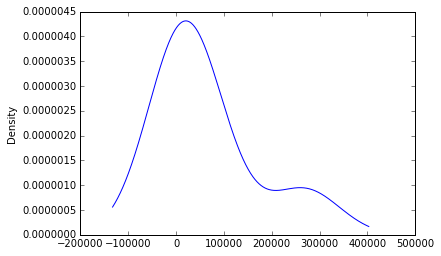

In [113]:
condition_counts.plot(kind='density')

In [112]:
for i in  [0, 20, 40, 60, 80, 100]:
    cdf['condition_' + str(i)] =  cdf.condition.apply(lambda x: 1 if x == i else 0 )

#### Description, title
  
* description                   380107 non-null object - no missing values
* title                         380107 non-null object
* vectorize with TF-IDF

#### Distance
  
* distance                      380107 non-null int64 - no missing values
* It looks like distance was calculated based on location from cookie file, so from my home, it's not relevant in general.

#### Owner
* owner_id                      380107 non-null int64
* Information about owner looks valueble, but in case of consignments it's not likely that the same person would sell the same tipe of item again and again. I will skip owners information.

#### Priority
* priority                      380107 non-null int64
* All observation have the same priority 100, will not use it

#### Reservable, reserved
* reservable                    380107 non-null bool
* reserved                      380107 non-null bool
* Only two offer has reservable=True, will not use it
* All offers have reserved=False, will not use it

In [257]:
cdf['payable'].value_counts()

False    211271
True      89033
Name: payable, dtype: int64

#### Price
  
* price                         380107 non-null float64 - no missing values
* target

### Save for later

* latitude                      380107 non-null float64
* listing_type                  380107 non-null int64
* location_name                 380107 non-null object
* longitude                     380107 non-null float64
* payable                       380107 non-null bool
* post_date                     380107 non-null object
* post_from_store_address       377435 non-null object
* review_status                 285697 non-null float64
* sold_date                     6486 non-null object
* sold_offer_id                 3862 non-null float64
* state                         380107 non-null int64


### Other

Doesn't look relevant

* get_full_url                  380107 non-null object
* get_img_medium_height         380107 non-null int64
* get_img_medium_width          380107 non-null int64
* get_img_permalink_large       380107 non-null object
* get_img_permalink_medium      380107 non-null object
* get_img_permalink_small       380107 non-null object
* get_img_small_height          380107 non-null int64
* get_img_small_width           380107 non-null int64
* get_small_square_thumbanil    380107 non-null object
* id                            380107 non-null int64
* image                         159857 non-null object
* image_mob_det_hd              380107 non-null object
* image_mob_list_hd             380107 non-null object

# Model

I will build recommendation model for each category. Switch to GraphLab Create.

In [284]:
import graphlab as gl
gl.canvas.set_target('ipynb')

In [282]:
apparel = gl.SFrame(apparel_category)
house = gl.SFrame(house_category)
phones = gl.SFrame(phones_category)

On the last step I'm going to use graphlab.nearest_neighbors to get top 5 nearest offers to display for user and choose median price value as recommendation. 

In [ ]:
gramms = ['new', 'used', 'unlocked', 'good condition', 'great condition', 'very good condition', 'never used']

Start with phones

In [286]:
phones['title_word_count'] = gl.text_analytics.tf_idf(phones['title'])
#phones['desc_word_count'] = gl.text_analytics.count_words(phones['description'])

In [341]:
pl = gl.text_analytics.count_ngrams(phones['description'], 2)
c = Counter()
for row in pl: 
    for key, value in row.iteritems():
        c[key] += value
c.most_common(50)

[('works on', 5553),
 ('street shoreline', 5328),
 ('521 ne', 5320),
 ('165th street', 5311),
 ('ne 165th', 5303),
 ('shoreline 98155', 5220),
 ('metro pcs', 5189),
 ('family mobile', 5141),
 ('go smart', 5121),
 ('simple mobile', 4911),
 ('straight talk', 4854),
 ('and many', 4542),
 ('many others', 4538),
 ('mobile go', 4521),
 ('tmobile simple', 4511),
 ('talk cricket', 4502),
 ('on any', 3613),
 ('cash only', 3463),
 ('no trades', 3434),
 ('trades cash', 3368),
 ('is 521', 3279),
 ('address is', 3279),
 ('in any', 3262),
 ('any country', 3250),
 ('network in', 3236),
 ('my other', 3218),
 ('on my', 3191),
 ('see my', 3176),
 ('to see', 3174),
 ('click on', 3157),
 ('please click', 3156),
 ('2o6 5787484', 3129),
 ('shop address', 3077),
 ('cricket h2o', 2982),
 ('10am to', 2977),
 ('only works', 2909),
 ('any network', 2886),
 ('me at', 2858),
 ('at 2o6', 2798),
 ('att straight', 2778),
 ('or call', 2751),
 ('text or', 2750),
 ('pcs family', 2743),
 ('from 10am', 2667),
 ('to 8pm', 

In [339]:
pl = gl.text_analytics.count_ngrams(apparel['title'], 2)
c = Counter()
for row in pl: 
    for key, value in row.iteritems():
        c[key] += value
c.most_common(30)

[('brand new', 1333),
 ('women s', 964),
 ('men s', 809),
 ('fisher price', 763),
 ('car seat', 684),
 ('wedding dress', 656),
 ('size 8', 637),
 ('baby girl', 636),
 ('north face', 614),
 ('size 10', 588),
 ('size 6', 570),
 ('true religion', 564),
 ('prom dress', 554),
 ('dress size', 500),
 ('leather jacket', 481),
 ('michael kors', 422),
 ('size 9', 405),
 ('size 7', 400),
 ('baby boy', 397),
 ('size 4', 390),
 ('size 12', 384),
 ('size 5', 384),
 ('jeans size', 373),
 ('miss me', 331),
 ('diaper bag', 330),
 ('air jordan', 326),
 ('shoes size', 322),
 ('0 3', 316),
 ('3 6', 316),
 ('carter s', 315)]

In [318]:
pl[0].keys()

['vtech home', 'home phone']

In [264]:
apparel_model = gl.nearest_neighbors.create(apparel_category,features=['deep_features'],label='id')
house_model = gl.nearest_neighbors.create(house_category,features=['deep_features'],label='id')
phone_model = gl.nearest_neighbors.create(phone_category,features=['deep_features'],label='id')

Add additional features for each category from title and description.

In [ ]:
## TF/IDF
    #vectorizer1 = TfidfVectorizer(encoding='english',
    #                            stop_words='english',
    #                            strip_accents="ascii",
    #                          # token_pattern=r'\w{3,}',
    #                           max_features=100)

    text_vec = df['description'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
    text_vec1 = zip(text_vec, df['name'], df['org_name'], df['payee_name'], df['org_desc'])
    text_vec1 = [ ''.join(ln) for ln in text_vec1]
    count_char = pd.Series(text_vec1)
    df["Numberof!"]    = count_char.apply(lambda x: x.count("!"))
    df["NumberofCaps"] = count_char.apply(lambda x: sum(1 for c in x if c.isupper()))
    
    tfidf_vec = joblib.load(tfidf_file)

    r       = tfidf_vec.transform(text_vec1)
    columns = tfidf_vec.get_feature_names()
    columns = [ 'tfidf_'+c for c in columns]
    temp    = pd.DataFrame(r.toarray(),columns=columns)


In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=55)

In [40]:
max(phones_category.price)

450000.0

In [39]:
phones_category.price.quantile([.1, .5, .99999999])

0.1        10.000000
0.5       149.000000
1.0    449937.411249
Name: price, dtype: float64

In [25]:
len(phones_category)

14307